In [1]:
import os
import h5py
import json
import random 
import imageio
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
Data = pd.read_csv('DsDnsPrScTch.csv') 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Data["Teacher First Project Posted Date"]=pd.to_datetime(Data["Teacher First Project Posted Date"])
Data["Project Fully Funded Date"]=pd.to_datetime(Data["Project Fully Funded Date"])
Data["Project Expiration Date"]=pd.to_datetime(Data["Project Expiration Date"])
Data["Project Posted Date"]=pd.to_datetime(Data["Project Posted Date"])
Data["Donation Received Date"]=pd.to_datetime(Data["Donation Received Date"])
Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]

In [4]:
Data.dtypes

Unnamed: 0                                          int64
Project ID                                         object
Donation ID                                        object
Donor ID                                           object
Donation Included Optional Donation                object
Donation Amount                                   float64
Donor Cart Sequence                                 int64
Donation Received Date                     datetime64[ns]
Donor City                                         object
Donor State                                        object
Donor Is Teacher                                   object
Donor Zip                                          object
Unnamed: 0.1                                        int64
School ID                                          object
Teacher ID                                         object
Teacher Project Posted Sequence                     int64
Project Type                                       object
Project Title 

C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    743945.000000
mean          0.462287
std           0.332363
min           0.000030
25%           0.138487
50%           0.480108
75%           0.742170
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


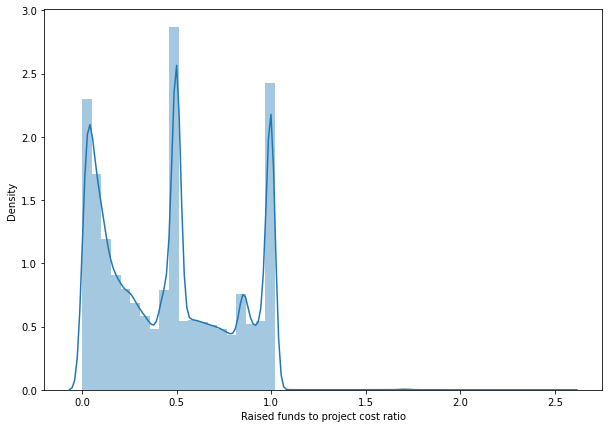

In [5]:
T=pd.Timedelta('30 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())


C:\Users\REDLINE PC\.conda\envs\Laptop\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    870802.000000
mean          0.555950
std           0.337268
min           0.000026
25%           0.255094
50%           0.500019
75%           0.889879
max           2.550013
Name: Raised funds to project cost ratio, dtype: float64


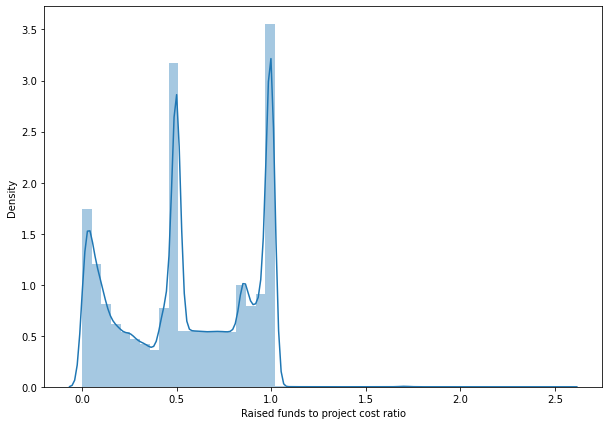

In [6]:
T=pd.Timedelta('120 days')
sub_var=["Number of dates since posted","Project ID","Donation Amount","Project Cost",
         "Project Posted Date","Project Expiration Date","Donation Received Date"]
sub_Data =Data.loc[:,sub_var]
sub_Data=sub_Data[sub_Data["Number of dates since posted"] < T]
sub_Data["Raised funds to project cost ratio"]=sub_Data["Donation Amount"]/sub_Data["Project Cost"]
Grouped_data=sub_Data.groupby(["Project ID"]).sum()
Grouped_data_Final = sub_Data.groupby(["Project ID"]).max()
Grouped_data_Final["Raised funds to project cost ratio"]=Grouped_data["Raised funds to project cost ratio"]

f, axes = plt.subplots(1, 1,figsize=(10,7))

y="Raised funds to project cost ratio"
q1 = Grouped_data_Final[y].quantile(0)
q3 = Grouped_data_Final[y].quantile(1)
mask = Grouped_data_Final[y].between(q1, q3, inclusive=True)
iqr = Grouped_data_Final.loc[mask, y]
sns.distplot(iqr, ax=axes,axlabel=y )
print(iqr.describe())

G120=Grouped_data_Final

In [7]:
#===============================================================================================
#                                  Model Training Funstion
#===============================================================================================

def Train_Model(Classifier,hyper_parameters, Model_variables_con,Model_variables_cat,Data,
                Time_period_indays=30,K=100,Fund_Ratio_treshold=0.142):
    # Time_period should be in days 
    # K is the Top-K value

    #=================================== Initiate the List Variables ================================
    
    Time_points = []
    Output=dict()
    count_itr=0
    
    Overall_Training_Accuracy_GS=[]
    Overall_Training_Precision_GS=[]
    Overall_Training_Recall_GS=[]

    Overall_Testing_Accuracy_GS=[]
    Overall_Testing_Precision_GS=[]
    Overall_Testing_Recall_GS=[]
    
    Overall_Top_K_Accuracy_GS=[]
    Overall_Top_K_Precision_GS=[]
    Overall_Top_K_Recall_GS=[]
    
    Classifier_models=[]
    
    #=================================== Initiate the Columns ======================================
    
    print("Initiatnig the Columns")
    Main_Variables = list(set(["Project ID","Project Posted Date","Project Expiration Date","Donation Received Date",
         "Project Cost","Donation Amount","Number of dates since posted"]+Model_variables_cat+Model_variables_con))
    Model_variables = Model_variables_con.copy()
    print("Variables considered in model training")
    for i in sub_var: print(">",i,i in Data.columns) # print all variables considered.
    print()
    Data["Number of dates since posted"]=Data.loc[:,"Donation Received Date"]-Data.loc[:,"Project Posted Date"]
    sub_Data = Data.loc[:,Main_Variables]
    sub_Data["Number of dates since posted"] = sub_Data["Number of dates since posted"]/ np.timedelta64(1, 'D')

    #================================= One-Hot-Encoding Columns to remove ==========================
    
    print("One-Hot-Encoding removing columns identification")
    Sub_Variables_to_remove=dict()
    for i in Model_variables_cat:
        sub_variables = Data[i].unique()
        Model_variables+=sorted([i+"_"+str(j) for j in Data[i].unique()])
        Model_variables.remove(i+"_"+str(sub_variables[0]))
        Sub_Variables_to_remove[i]=sub_variables[0]
        
    
    
    
    
    #======================================= Grid Search ===========================================
    keys=list(hyper_parameters.keys())
    vals=[]
    
    for i in keys:
        vals+=[hyper_parameters[i]]

    combinations=vals[0]
    for i in range (1,len(vals)):
        combinations = list(itertools.product(combinations,vals[i]))

    for i in range (len (combinations)): #tupples to single list
        try:
            p=list(combinations[i][0])
        except:
            p=[combinations[i][0]]
            
        for j in range (1,len(combinations[i])):
            p+=[combinations[i][j]]
        combinations[i]=p    


    for i in combinations:
        for j in range (len(keys)):
            setattr(Classifier, keys[j],i[j])
        print(Classifier)
        count_itr+=1
        print(count_itr,"/",len(combinations),"Time iteration is starting\n")
        #=================================== Initiate Time Variables ====================================
    
        print("Initiate Time Variables")
        MaxT = pd.Timestamp("2018-05-01 00:00:00")  #max(Data["Project Posted Date"])
        MinT = pd.Timestamp("2013-01-01 00:00:00")  #min(Data["Project Posted Date"])
        Time_period = timedelta(days=Time_period_indays)  
        T_current = MinT- Time_period +timedelta(days=120) 
        

        #=================================== Loop over time frams =======================================
        
        Output["Overall_Training_Accuracy"], Output["Overall_Training_Precision"], Output["Overall_Training_Recall"] = list(),list(),list()
        Output["Overall_Testing_Accuracy"], Output["Overall_Testing_Precision"], Output["Overall_Testing_Recall"] = list(),list(),list()
        Output["Top_K_Accuracy"], Output["Top_K_Precision"], Output["Top_K_Recall"] = list(),list(),list()
        
        print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

        print("Time iteration is starting\n")
        while (T_current<MaxT-Time_period):

            T_current = T_current+ Time_period
            Time_points+=[T_current]
            T_Train_start = T_current-timedelta(days=120)  # Start of the data frame
            T_Train_end = T_current-Time_period  #End of the data frame
            print("As of Date:",T_current,"\n"+"="*85)

        #====================================== Extract the frams ======================================= 

            # Extracts projects posted before the Current(As of) date
            Data_in_TimeWindow = sub_Data[sub_Data["Project Posted Date"] < pd.to_datetime(T_current)]  

            # Extracts projects posted after the start date of the Time window
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] > pd.to_datetime(T_Train_start)]

            #Time period to be consided for the donations since posted (30days, as default)
            Data_in_TimeWindow = Data_in_TimeWindow[Data_in_TimeWindow["Number of dates since posted"]< Time_period_indays]

            #Express the donation amount as a ratio of to the Project cost
            Data_in_TimeWindow["Fund_Ratio"]=Data_in_TimeWindow["Donation Amount"]/Data_in_TimeWindow["Project Cost"]


        #=========================== Do One-Hot_Encoding for Categorical Variables ======================

            for var in Model_variables_cat:
                Sub_Dummied_Data=pd.get_dummies(Data_in_TimeWindow[var])  #create dummpy variables with one hot encoding 
                Sub_Dummied_Data_columns=sorted(Sub_Dummied_Data.columns)  #extract the column names of dummpy variables
                Sub_Dummied_Data_columns.remove(Sub_Variables_to_remove[var]) #remove a pre defined column from dummpy variables
                Data_in_TimeWindow=Data_in_TimeWindow.drop([var], axis=1) #remove main variable from the dataset
                #copy the columns to the main data set 
                for col in Sub_Dummied_Data_columns : Data_in_TimeWindow[var+"_"+col] = Sub_Dummied_Data[col]

            #Add the columns which have not been one-hot-encoded
            for i in Model_variables:
                if i not in Data_in_TimeWindow.columns:  Data_in_TimeWindow[i]=0


        #============================================ Imputing ==========================================
            Data_in_TimeWindow.fillna(Data_in_TimeWindow.median(), inplace=True)


        #=================================== Training set Creation =====================================

            #extract the training set from the timewindow
            Train_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] < pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Train_Data_CR=Train_Data.groupby(["Project ID"]).sum() 
            Train_Data_Final=Train_Data.groupby(["Project ID"]).max()
            Train_Data_Final["Fund_Ratio"]=Train_Data_CR["Fund_Ratio"]
            Train_Data_Final["Donation Amount"]=Train_Data_CR["Donation Amount"]

            # Define Fund_Ratio_Treshold
            Fund_Ratio_Treshold = Fund_Ratio_treshold
            Fund_Ratio_Treshold = Train_Data_Final["Fund_Ratio"].median()

            # Genarate the Label for the dataset 
            Train_Data_Final['Label'] = Train_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                               Fund_Ratio_Treshold  else 0, axis=1)

            X_train = Train_Data_Final.loc[:,Model_variables]
            Y_train = np.array(Train_Data_Final.loc[:,["Label"]])[:,0]


        #==================================== Testing set Creation =====================================

            #extract the training set from the timewindow
            Test_Data = Data_in_TimeWindow[Data_in_TimeWindow["Project Posted Date"] >= pd.to_datetime(T_Train_end)]

            #Group by Project ID
            Test_Data_CR=Test_Data.groupby(["Project ID"]).sum() 
            Test_Data_Final=Test_Data.groupby(["Project ID"]).max()
            Test_Data_Final["Fund_Ratio"]=Test_Data_CR["Fund_Ratio"]
            Test_Data_Final["Donation Amount"]=Test_Data_CR["Donation Amount"]

            # Genarate the Label for the dataset 
            Test_Data_Final['Label'] = Test_Data_Final.apply(lambda x : 1  if x['Fund_Ratio'] < 
                                                             Fund_Ratio_Treshold  else 0, axis=1)
            X_test = Test_Data_Final.loc[:,Model_variables]
            Y_test = np.array(Test_Data_Final.loc[:,["Label"]])[:,0]


        #===================================== Model Training =========================================

            Classifier.fit(X_train, Y_train)

            # Predict on training 
            Train_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_train)[:,1]
            Train_Data_Final["Y_pred"]= Classifier.predict(X_train)
            # Predict on testing 
            Test_Data_Final["Y_pred_prob"] = Classifier.predict_proba(X_test)[:,1]
            Test_Data_Final["Y_pred"] = Classifier.predict(X_test)


        #====================================== Evaluation Trainign  ============================================

            Training_CM= confusion_matrix(Y_train,Train_Data_Final["Y_pred"])
            Training_TN, Training_FP ,Training_FN, Training_TP =  Training_CM.ravel()

            Training_Accuracy=(Training_TP+Training_TN)/(Training_TN+ Training_FP +Training_FN+ Training_TP)
            Training_Precision=Training_TP/(Training_TP+Training_FP)
            Training_Recall=Training_TP/(Training_TP+Training_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Training_Accuracy)
            print("\tTraining_TP:",Training_TP,"\tTraining_FP:",Training_FP,
                  "\n\tTraining_TN:",Training_TN,"\tTraining_FN:",Training_FN ,end="\n"*2)


        #====================================== Evaluation Testign  ============================================   

            Testing_CM= confusion_matrix(Y_test,Test_Data_Final["Y_pred"])
            Testing_TN, Testing_FP ,Testing_FN, Testing_TP =  Testing_CM.ravel()

            Testing_Accuracy=(Testing_TP+Testing_TN)/(Testing_TN+ Testing_FP +Testing_FN+ Testing_TP)
            Testing_Precision=Testing_TP/(Testing_TP+Testing_FP)
            Testing_Recall=Testing_TP/(Testing_TP+Testing_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Accuracy)
            print("\tTesting_TP:",Testing_TP,"\tTesting_FP:",Testing_FP,
                  "\n\tTesting_TN:",Testing_TN,"\tTesting_FN:",Testing_FN ,end="\n"*2)

        #====================================== Evaluation Top K  ============================================        

            Test_Data_Final=Test_Data_Final.sort_values(by=['Y_pred_prob'], ascending=False)
            Top_K=Test_Data_Final.head(K)
            Y_test_Top_K =  Top_K.loc[:,["Label"]] 
            Y_pred_Top_K =  Top_K.loc[:,["Y_pred"]]
            Testing_Top_K_CM= confusion_matrix(Y_test_Top_K,Y_pred_Top_K)
            if len(Testing_Top_K_CM.ravel())==4:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP =  Testing_Top_K_CM.ravel()
            else:
                Testing_Top_K_TN, Testing_Top_K_FP ,Testing_Top_K_FN, Testing_Top_K_TP=0,0,0,K

            Testing_Top_K_Accuracy=(Testing_Top_K_TP+Testing_Top_K_TN)/(Testing_Top_K_TN
                                                                        + Testing_Top_K_FP +Testing_Top_K_FN+ Testing_Top_K_TP)
            Testing_Top_K_Precision=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FP)
            Testing_Top_K_Recall=Testing_Top_K_TP/(Testing_Top_K_TP+Testing_Top_K_FN)

            print(Classifier.__class__.__name__,' Testing Accuracy = ',Testing_Top_K_Accuracy)
            print("\tTesting_Top_K_TP:",Testing_Top_K_TP,"\tTesting_Top_K_FP:",Testing_Top_K_FP,
                  "\n\tTesting_Top_K_TN:",Testing_Top_K_TN,"\tTesting_Top_K_FN:",Testing_Top_K_FN ,end="\n"*2)

         #====================================== save computed values  ============================================       
            Output["Overall_Training_Accuracy"] += [Training_Accuracy]
            Output["Overall_Training_Precision"] += [Training_Precision]
            Output["Overall_Training_Recall"] += [Training_Recall ]

            Output["Overall_Testing_Accuracy"] += [Testing_Accuracy]
            Output["Overall_Testing_Precision"] += [Testing_Precision]
            Output["Overall_Testing_Recall"] += [Testing_Recall]

            Output["Top_K_Accuracy"] += [Testing_Top_K_Accuracy] 
            Output["Top_K_Precision"] += [Testing_Top_K_Precision]  
            Output["Top_K_Recall"] += [Testing_Top_K_Recall] 
            
            
        Overall_Training_Accuracy_GS+=[sum(Output["Overall_Training_Accuracy"])/len(Output["Overall_Training_Accuracy"])]
        Overall_Training_Precision_GS+=[sum(Output["Overall_Training_Precision"])/len(Output["Overall_Training_Precision"])]
        Overall_Training_Recall_GS+=[sum(Output["Overall_Training_Recall"])/len(Output["Overall_Training_Recall"])]

        Overall_Testing_Accuracy_GS+=[sum(Output["Overall_Testing_Accuracy"])/len(Output["Overall_Testing_Accuracy"])]
        Overall_Testing_Precision_GS+=[sum(Output["Overall_Testing_Precision"])/len(Output["Overall_Testing_Precision"])]
        Overall_Testing_Recall_GS+=[sum(Output["Overall_Testing_Recall"])/len(Output["Overall_Testing_Recall"])]

        Overall_Top_K_Accuracy_GS+=[sum(Output["Top_K_Accuracy"])/len(Output["Top_K_Accuracy"])]
        Overall_Top_K_Precision_GS+=[sum(Output["Top_K_Precision"])/len(Output["Top_K_Precision"])]
        Overall_Top_K_Recall_GS+=[sum(Output["Top_K_Recall"])/len(Output["Top_K_Recall"])]
        
        Classifier_models+=[Classifier]
        
    
    
    Output["Overall_Training_Accuracy"] = Overall_Training_Accuracy_GS
    Output["Overall_Training_Precision"] =Overall_Training_Precision_GS
    Output["Overall_Training_Recall"] =Overall_Training_Precision_GS

    Output["Overall_Testing_Accuracy"] =Overall_Testing_Accuracy_GS
    Output["Overall_Testing_Precision"] =Overall_Testing_Precision_GS
    Output["Overall_Testing_Recall"] =Overall_Testing_Recall_GS

    Output["Top_K_Accuracy"] = Overall_Top_K_Accuracy_GS
    Output["Top_K_Precision"] = Overall_Top_K_Precision_GS
    Output["Top_K_Recall"] = Overall_Top_K_Recall_GS
    
    Output["Classifier"]=Classifier_models
    Output["Model_variables"]=Model_variables
    Output["Time_points"]=Time_points
    
    print(Overall_Training_Accuracy_GS)
    return Output,Test_Data_Final,Train_Data_Final
        

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(random_state=1,fold_permutation_block=0,task_type="GPU",devices='0:1')

hyper_para=dict()
hyper_para["learning_rate"]=[0.1,0.03,0.003,0.0003]
hyper_para["iterations"]=[100,200,500,1000]
hyper_para["max_depth"]=[10,15,20,40]
# hyper_para["criterion"]=["gini", "entropy"]

Model_variables_con= ["Project Cost","Number of dates since posted","School Percentage Free Lunch",
                      "Project Short Description_polarity","Project Short Description_subjectivity",
                      "Project Essay_polarity","Project Essay_subjectivity","Project Need Statement_polarity",
                      "Project Need Statement_subjectivity"]
Model_variables_cat= ["School Metro Type","Teacher Prefix","Project Grade Level Category"]

Output,Test_Data_Final,Train_Data_Final= Train_Model(clf, hyper_para,Model_variables_con,Model_variables_cat,
                                    Data,Time_period_indays=30,K=100,Fund_Ratio_treshold=0.14)

In [ ]:
# keys=list(hyper_para.keys())
# vals=[]

# for i in keys:
#     vals+=[hyper_para[i]]

# combinations=vals[0]
# for i in range (1,len(vals)):
#     combinations = list(itertools.product(combinations,vals[i]))

    
# for i in range (len (combinations)):
#     try:
#         p=list(combinations[i][0])
#     except:
#         p=[combinations[i][0]]
#     for j in range (1,len(combinations[i])):
#         p+=[combinations[i][j]]
#     combinations[i]=p    


# for i in combinations:
#     for j in range (len(keys)):
#         setattr(clf_h, keys[j],i[j])
#     print(clf_h)
    

In [ ]:
Output.keys()

In [ ]:
n_cols=3
n_rows=1
fig, axs=plt.subplots(n_rows,n_cols,figsize=(n_cols*6,n_rows*4))

ax = axs[0]
ax.plot(Output["Overall_Training_Recall"],label='Training_Recall')
ax.plot(Output["Overall_Training_Precision"],label='Training_Precision')
ax.plot(Output["Overall_Training_Accuracy"],label='Training_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Training",fontsize=15);

ax = axs[1]
ax.plot(Output["Overall_Testing_Recall"],label='Testing_Recall')
ax.plot(Output["Overall_Testing_Precision"],label='Testing_Precision')
ax.plot(Output["Overall_Testing_Accuracy"],label='Testing_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Testing",fontsize=15);

ax = axs[2]
ax.plot(Output["Top_K_Recall"],label='Top_K_Recall')
ax.plot(Output["Top_K_Precision"],label='Top_K_Precision')
ax.plot(Output["Top_K_Accuracy"],label='Top_K_Accuracy')
ax.legend()
ax.set_xlabel("Time in years",fontsize=15);
ax.set_ylabel("Top_K",fontsize=15);



In [ ]:
for i in range (len(Output["Overall_Testing_Accuracy"])):
    print("=========================================",i,"==================================================")
    print("TeA=",Output["Overall_Testing_Accuracy"][i],"TeP=",Output["Overall_Testing_Precision"][i],
          "TeR=",Output["Overall_Testing_Recall"][i])
    print("KA=",Output["Top_K_Accuracy"][i],"KP=",Output["Top_K_Precision"][i],
          "KR=",Output["Top_K_Recall"][i])
    print(Output["Classifier"][i])
   